In [1]:
import pandas as pd
from collections import Counter
import spacy,re,json
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy import displacy  

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

import re
from pprint import pprint
import os
import warnings
warnings.filterwarnings('ignore')

from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding

# ============================================================
## 基于 Spacy 的 NER 模型

In [2]:
PATH ='data/file_ner.json1'

annotated_data = []
lines=[]
with open(PATH, 'r',encoding = 'utf-8 sig') as f:
    lines = f.readlines()

for line in lines:
    data = json.loads(line)
    text = data['text']
    entities = []
    for label in data['labels']:
        entities.append(label)
    annotated_data.append((text, {"entities": data['labels']}))

In [3]:
training_data=  annotated_data[0:200]
test_data = annotated_data[200:220]

In [4]:
print(len(training_data), len(test_data))

200 20


In [5]:
training_data[0]

('"Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company\'s growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (

In [6]:
def main(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in training_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # reset and initialize the weights randomly – but only if we're
        # training a new model
        if model is None:
            nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(training_data)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

    # test the trained model
    for text, _ in training_data:
        doc = nlp(text)
#         print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
#         print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        for text, _ in training_data:
            doc = nlp2(text)
#             print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
#             print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

# trained this model with 100 iterations in google colab using GPU runtime with loss: Losses {'ner': 465.24571515528373} 
main(output_dir='ner_model/') 

Created blank 'en' model
Losses {'ner': 16889.961593902088}
Losses {'ner': 2697.5885606127285}
Losses {'ner': 2744.089724993466}
Losses {'ner': 2825.1706454027}
Losses {'ner': 2487.06796729747}
Losses {'ner': 2293.7671482911956}
Losses {'ner': 2414.592029980423}
Losses {'ner': 2079.5062248590334}
Losses {'ner': 2140.9136387828835}
Losses {'ner': 2115.5998387992677}
Losses {'ner': 2140.5686549975217}
Losses {'ner': 1773.3107981665094}
Losses {'ner': 1749.3125200521604}
Losses {'ner': 1783.7525714743247}
Losses {'ner': 1749.503419123001}
Losses {'ner': 1792.6353750283993}
Losses {'ner': 1580.5342176150768}
Losses {'ner': 1474.0500409663866}
Losses {'ner': 1522.7503911667266}
Losses {'ner': 1523.5194834165798}
Losses {'ner': 1464.960874043458}
Losses {'ner': 1388.104255991477}
Losses {'ner': 1335.1260102155413}
Losses {'ner': 1285.2708202728818}
Losses {'ner': 1266.5353707549868}
Losses {'ner': 1189.9840920108427}
Losses {'ner': 1132.8286302185863}
Losses {'ner': 1375.8248131792627}
Losse

# ==========================================================
## 导入 NER 模型，识别 JD 中的所有技能类关键词

In [28]:
ner_model = spacy.load('ner_model/')

In [29]:
skill_set = {}
link_set = {}

In [30]:
ind = 0

for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        try:
            #获取文件路径
            my_file = open( os.path.join(root,file),encoding = 'utf-8' )
            my_string = my_file.readlines()

            for string in my_string[1:]:
                doc = ner_model( string )

                temp_list = []
                for chunk in doc.ents:
                    temp_list.append( chunk.text )
                    
                temp_set = set( temp_list )
                
                for tem in list(temp_set):
                    if tem not in skill_set.keys():
                        print( tem )
                        
                    if skill_set.get( tem, 0 ) == 0:
                        skill_set[tem] = 1
                    else:
                        skill_set[tem] += 1
                        
                for t1 in list(temp_set):
                    for t2 in list(temp_set):
                        if t1.text != t2.text:
                            if link_set.get( t1+'|'+t2, 0 ) == 0:
                                link_set[t1+'|'+t2] = 1
                            else:
                                link_set[t1+'|'+t2] += 1
                            

            my_file.close()
        
            if ind % 100 == 0:
                print( '------------------------------------------------------------------------',ind )
                
#             if ind > 2000:
#                 break
                
        except:
            pass

Machine Learning
Python
BlackRock
SQL
artificial intelligence
R
C++
Map/Reduce
Linux
Java
C
SAS
MATLAB
PHP
Data Pre
data modeling
Deep Learning
via SQL
software prototyping
C ##
Advanced knowledge
Javascript
C#
Spark
Practical experience
Consumer experience
TensorFlow
Hadoop
Data Analytics
Adhoc analysis
comparable NoSQL
Monica
·
Data Scientist
PowerPoint
Program Management Services; Testing
Business Intelligence
Infrastructure Support
SAP HANA
AWS
Informatica
Cloud Enablement Services
Excel
Redshift
S3
recruitment
Athena
Kinesis My
SPSS
Tensorflow
feature engineering
Matlab
Microsoft Office
problem-solving
predictive
Oracle
non-parametric statistical
MS Windows
Visualization
Data engineering
Problem Solving
Unit testing
predictive analytics
NoSQL 11
Perl
Analytics Experience
Predictive
ETL
Context
NoSQL
Tennessee 38116
machine learning
Advanced SQL
Data/Advanced Analytics
Data Visualization
Artificial Intelligence
Data Platform
Florida
GitHub
predictive modeling
BigQuery
Data Mining
f

Dallas
Microsoft Visio
SCAN
Microsoft Recruitment
Pig
Tableau R
and/or NoSQL
Prescriptive Analytics
MS Word
Application Development
Operations
Marketing Analytics
Data Scientist Opening
5522

CONSUMER BNKG
enterprise analytics
Random Forests
Deterministic Forests
xkcd
Facebook Analytics
Search Engine Marketing
Python/R
Technical Game Analytics
Director
Julia
NOSQL
team player
SQUARESPACE
CPT
-----------------
Data Integration patterns
Data/Customer Analytics
marketing analytics
------------------------------------------------------------------------ 1900
Python/PySpark
MIT 2014
Text Analytics
Azure Databricks
Azure Kubernetes Services
SystemML
Neon
Data Governance
Data Intelligence
R SQL
Kafka Internet of Things
Judgment/
including JavaScript
SQL Experience
Powerpoint
Assessments (A&A
e.g. Java
Network Management
Distribution Management System (DMS)
Ensembling
Data Analyts
Trianz
------------------------------------------------------------------------ 2000
data blending
course performa

------------------------------------------------------------------------ 5100
via cvojick@apexsystems.com
Builds predictive
TX 75014
4
fraud detection
Data management
Menlo Ventures
rapid prototyping
Conduent
Prototyping
Power BI / Tableau
using R
strong SQL experience
2
end
Infosys Consulting
javascript
css
Information Management
software development experience
Vrbo
Data concepts
problem solvers
values fit
relationship skills
decision engineering support
PowerShell
Deep Learning networks
similar field
------------------------------------------------------------------------ 5300
Data ScientistPython
Risk Analytics
regression testing
nginx
php
html
GCP

Linux shell script
MS Visual Studio
Windows
differential privacy algorithms
Linear
Non-linear
link analysis
We’re growing;
Data experts
JMP
Predictive analytics
Google Cloud Composer
PL/SQL/ MySQL
Service Engineering Operations
Plymouth Meeting
Data systems
speech analytics
application server
---------------------------------------------

In [32]:
skill_set = dict( Counter(skill_set).most_common(300) )
skill_set

{'Python': 950,
 'SQL': 695,
 'R': 502,
 'machine learning': 485,
 'Machine Learning': 334,
 'SAS': 334,
 'Data Scientist': 327,
 'Java': 279,
 'Spark': 264,
 'C++': 258,
 'Hadoop': 207,
 'C': 169,
 'AWS': 167,
 'Deep Learning': 152,
 'problem solving': 143,
 'deep learning': 128,
 'TensorFlow': 112,
 'S3': 112,
 'NoSQL': 110,
 'predictive analytics': 101,
 'Analytics': 100,
 'Artificial Intelligence': 99,
 'Linux': 94,
 'SPSS': 91,
 'Data Analytics': 87,
 'problem-solving': 86,
 'predictive modeling': 85,
 'Tensorflow': 83,
 'Oracle': 83,
 'Azure': 83,
 'EC2': 83,
 'comparable NoSQL': 79,
 'JavaScript': 74,
 'artificial intelligence': 68,
 'MATLAB': 66,
 'Redshift': 65,
 'Excel': 60,
 'Data Visualization': 60,
 'research': 60,
 'Microsoft Office': 59,
 'SQL Server': 57,
 'C#': 56,
 'Power BI': 55,
 'MS Office': 54,
 'PHP': 53,
 'ETL': 53,
 'PostgreSQL': 53,
 'Tableau': 52,
 'Predictive Analytics': 50,
 'MySQL': 49,
 'advanced analytics': 49,
 'statistical modeling': 47,
 'Unix': 47,
 

# ============================================================
## 基于句法分析抽取层级关系

In [33]:
nlp = spacy.load("en_core_web_sm")

In [34]:
def is_father( word, root ):
    if word == root:
        return True
    
    while word != word.head:
        word = word.head
        if word == root:
            return True
    
    return False

In [35]:
ind = 0

total_link_list = []
for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        my_file = open( os.path.join(root,file),encoding = 'utf-8' )

        my_string = my_file.readlines()
        for string_list in my_string[1:]:
            string_list = string_list.replace('e.g.','like')
            string_list = string_list.replace('.)',')')
#             for string in [sentence for sentence in re.split(r'[？?！!。；;：:\n\r·]', string_list) if sentence]:
            for string in re.split(r'[？?！!。.；;：:\n\r·•*]', string_list):
#                 try:
                doc = nlp( string )

                my_chunks_list = []
                roor_chunks_dict = {}

                for chunk in doc.noun_chunks:
                    if chunk.text in skill_set.keys():
                        my_chunks_list.append( chunk.root )
                        roor_chunks_dict[ str(chunk.root)] = str(chunk)

                if len( my_chunks_list ) > 1:
#                     print( 'skill word:', my_chunks_list )
                    Total_List = []

                    for word in my_chunks_list:
                        temp_list = []
                        temp_list.append(word)

                        pre = word
                        while word != word.head:
                            pre = word
                            relation = word.dep_
                            word = word.head

                            if 'N' in word.tag_ and (relation != 'conj' and relation != 'appos'):
                                if word in my_chunks_list:
                                    temp_list.append( word )

                                    if len( [str( roor_chunks_dict[str(w)] ) for w in temp_list if 'xperience' not in str(w)] ) == 2:
                                            print(string)
                                            print('result1:')  
                                            print( '-->'.join([str( roor_chunks_dict[str(w)] ) for w in temp_list]) )
                                            total_link_list.append( [str( roor_chunks_dict[str(w)] ) for w in temp_list] )
                                            print()

                                else:
                                    tree_list = []
                                    for t in my_chunks_list:
                                        if t.dep_ == 'compound' and is_father( t, word ) == True and is_father( t, pre ) == False:
                                            tree_list.append( t )

                                    if len(tree_list) == 1:
                                        key1 = roor_chunks_dict[ str(temp_list[0]) ]
                                        key2 = roor_chunks_dict[ str(tree_list[0]) ]
                                        
                                        if 'xperience' not in key1 and 'xperience' not in key2:
                                            print(string)
                                            print('result2:')  
                                            
                                            print( '-->'.join( [ key1, key2 ] ) )
                                            total_link_list.append( [ key1, key2 ] )
                                            print()
                                break
                
        my_file.close()

        if ind % 500 == 0:
            print( '==================================================',ind )
            
        if ind > 500:
            break

Experience with sophisticated analyses (like, longitudinal modeling, machine learning, non-parametric statistical modeling) and data visualization (like, Tableau, Qlik, R Shiny, Microstrategy) is preferred
result1:
Tableau-->data visualization

 Experience with sophisticated analyses (like, longitudinal modeling, machine learning, non-parametric statistical modeling) and data visualization (like, Tableau, Qlik, R Shiny, Microstrategy) is preferred
result1:
Tableau-->data visualization

Advanced skill in use of Microsoft Office, including Outlook, Excel, Word, PowerPoint, and other computer applications including but not limited to skill in using shortcuts, macros, visual basic editing and advanced formulas)
result1:
Excel-->Microsoft Office

Advanced skill in use of Microsoft Office, including Outlook, Excel, Word, PowerPoint, and other computer applications including but not limited to skill in using shortcuts, macros, visual basic editing and advanced formulas)
result1:
Word-->Micros

In [36]:
ind = 0

total_link_list = []
for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        my_file = open( os.path.join(root,file),encoding = 'utf-8' )

        my_string = my_file.readlines()
        for string_list in my_string[1:]:
            string_list = string_list.replace('e.g.','like')
            string_list = string_list.replace('.)',')')
#             for string in [sentence for sentence in re.split(r'[？?！!。；;：:\n\r·]', string_list) if sentence]:
            for string in re.split(r'[？?！!。.；;：:\n\r·•*]', string_list):
#                 try:
                doc = nlp( string )

                my_chunks_list = []
                roor_chunks_dict = {}

                for chunk in doc.noun_chunks:
                    if chunk.text in skill_set.keys():
                        my_chunks_list.append( chunk.root )
                        roor_chunks_dict[ str(chunk.root)] = str(chunk)

                if len( my_chunks_list ) > 1:
#                     print( 'skill word:', my_chunks_list )
                    Total_List = []

                    for word in my_chunks_list:
                        temp_list = []
                        temp_list.append(word)

                        pre = word
                        while word != word.head:
                            pre = word
                            relation = word.dep_
                            word = word.head

                            if 'N' in word.tag_ and (relation != 'conj' and relation != 'appos'):
                                if word in my_chunks_list:
                                    temp_list.append( word )

                                    if len( [str( roor_chunks_dict[str(w)] ) for w in temp_list if 'xperience' not in str(w)] ) == 2:
                                            print( '-->'.join([str( roor_chunks_dict[str(w)] ) for w in temp_list]) )
                                            total_link_list.append( [str( roor_chunks_dict[str(w)] ) for w in temp_list] )

                                else:
                                    tree_list = []
                                    for t in my_chunks_list:
                                        if t.dep_ == 'compound' and is_father( t, word ) == True and is_father( t, pre ) == False:
                                            tree_list.append( t )

                                    if len(tree_list) == 1:
                                        key1 = roor_chunks_dict[ str(temp_list[0]) ]
                                        key2 = roor_chunks_dict[ str(tree_list[0]) ]
                                        
                                        if 'xperience' not in key1 and 'xperience' not in key2:
                                            print( '-->'.join( [ key1, key2 ] ) )
                                            total_link_list.append( [ key1, key2 ] )
                                break
                                    
        my_file.close()

        if ind % 500 == 0:
            print( '==================================================',ind )

Tableau-->data visualization
Tableau-->data visualization
Excel-->Microsoft Office
Word-->Microsoft Office
PowerPoint-->Microsoft Office
Python-->Java
SQL-->relational databases
SQL-->relational databases
SQL-->relational databases
================================================== 500
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
hypothesis testing-->statistical analysis
Tableau-->data visualization
hypothesis testing-->statistical analysis
hypothesis testing-->statistical analysis
Python-->Java
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
testing-->software development
MySQL-->databases
Python-->data visualization
R-->data visual

Word-->Microsoft Office
Excel-->Microsoft Office
PowerPoint-->Microsoft Office
analytics-->analytics
R-->statistical modeling
SAS-->statistical modeling
Python-->statistical modeling
hypothesis testing-->statistics
================================================== 5500
Python-->Visualization
hypothesis testing-->statistics
hypothesis testing-->statistics
Python-->Visualization
Python-->predictive modeling
Tensorflow-->Deep learning
PyTorch-->Deep learning
Keras-->Deep learning
Tensorflow-->Deep learning
PyTorch-->Deep learning
Keras-->Deep learning
================================================== 6000
Python-->statistical analysis
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
machine learning-->advanced analytics
data visualization-->advanced analytics
optimization-->advanced analytics
Word-->Microsoft Office
Excel-->Microsoft Office
PowerPoint-->Microsoft Office
research-->ma

In [37]:
link_df = pd.DataFrame( total_link_list )
link_df = link_df.rename(columns = {0:'node1',1:'node2'})
link_df

,node1,node2
0,Tableau,data visualization
1,Tableau,data visualization
2,Excel,Microsoft Office
3,Word,Microsoft Office
4,PowerPoint,Microsoft Office
...,...,...
448,optimization,advanced analytics
449,predictive modeling,advanced analytics
450,machine learning,advanced analytics
451,optimization,advanced analytics


# 关系绘制

In [38]:
from unittest.mock import patch
from nose.tools import assert_equal, assert_in
from pyecharts import options as opts
from pyecharts.charts.basic_charts.graph import Graph

from pyecharts import options as opts
from pyecharts.charts import Graph

nodes = []
links = []

nodes_set = []

for ind, row in link_df.iterrows():
    
    if row['node1'] != row['node2']:
        
        if row['node1'] not in nodes_set:
            nodes_set.append( row['node1'] )
            nodes.append( {'name': row['node1'] , "symbolSize": 15 + skill_set[row['node1']] / 20 } )
            
        if row['node2'] not in nodes_set:
            nodes_set.append( row['node2'] )
            nodes.append( {'name': row['node2'] , "symbolSize": 15 + skill_set[row['node2']] / 20 } )
        
        links.append({"source": row['node2'], "target": row['node1']})

Graph().add(
    "", 
    nodes, 
    links, 
    repulsion=8000,
#     linestyle_opts=opts.LineStyleOpts(width=2, curve=0.1, opacity=0.9),
    linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
    label_opts=opts.LabelOpts( ),
    categories=None,
    is_focusnode=True,
#     layout="none",
    is_roam=True
    
).set_global_opts(title_opts=opts.TitleOpts(title="Graph-基本示例")).render_notebook()

# 关系绘制

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Input data files check
# from subprocess import check_output

In [40]:
link_df

,node1,node2
0,Tableau,data visualization
1,Tableau,data visualization
2,Excel,Microsoft Office
3,Word,Microsoft Office
4,PowerPoint,Microsoft Office
...,...,...
448,optimization,advanced analytics
449,predictive modeling,advanced analytics
450,machine learning,advanced analytics
451,optimization,advanced analytics


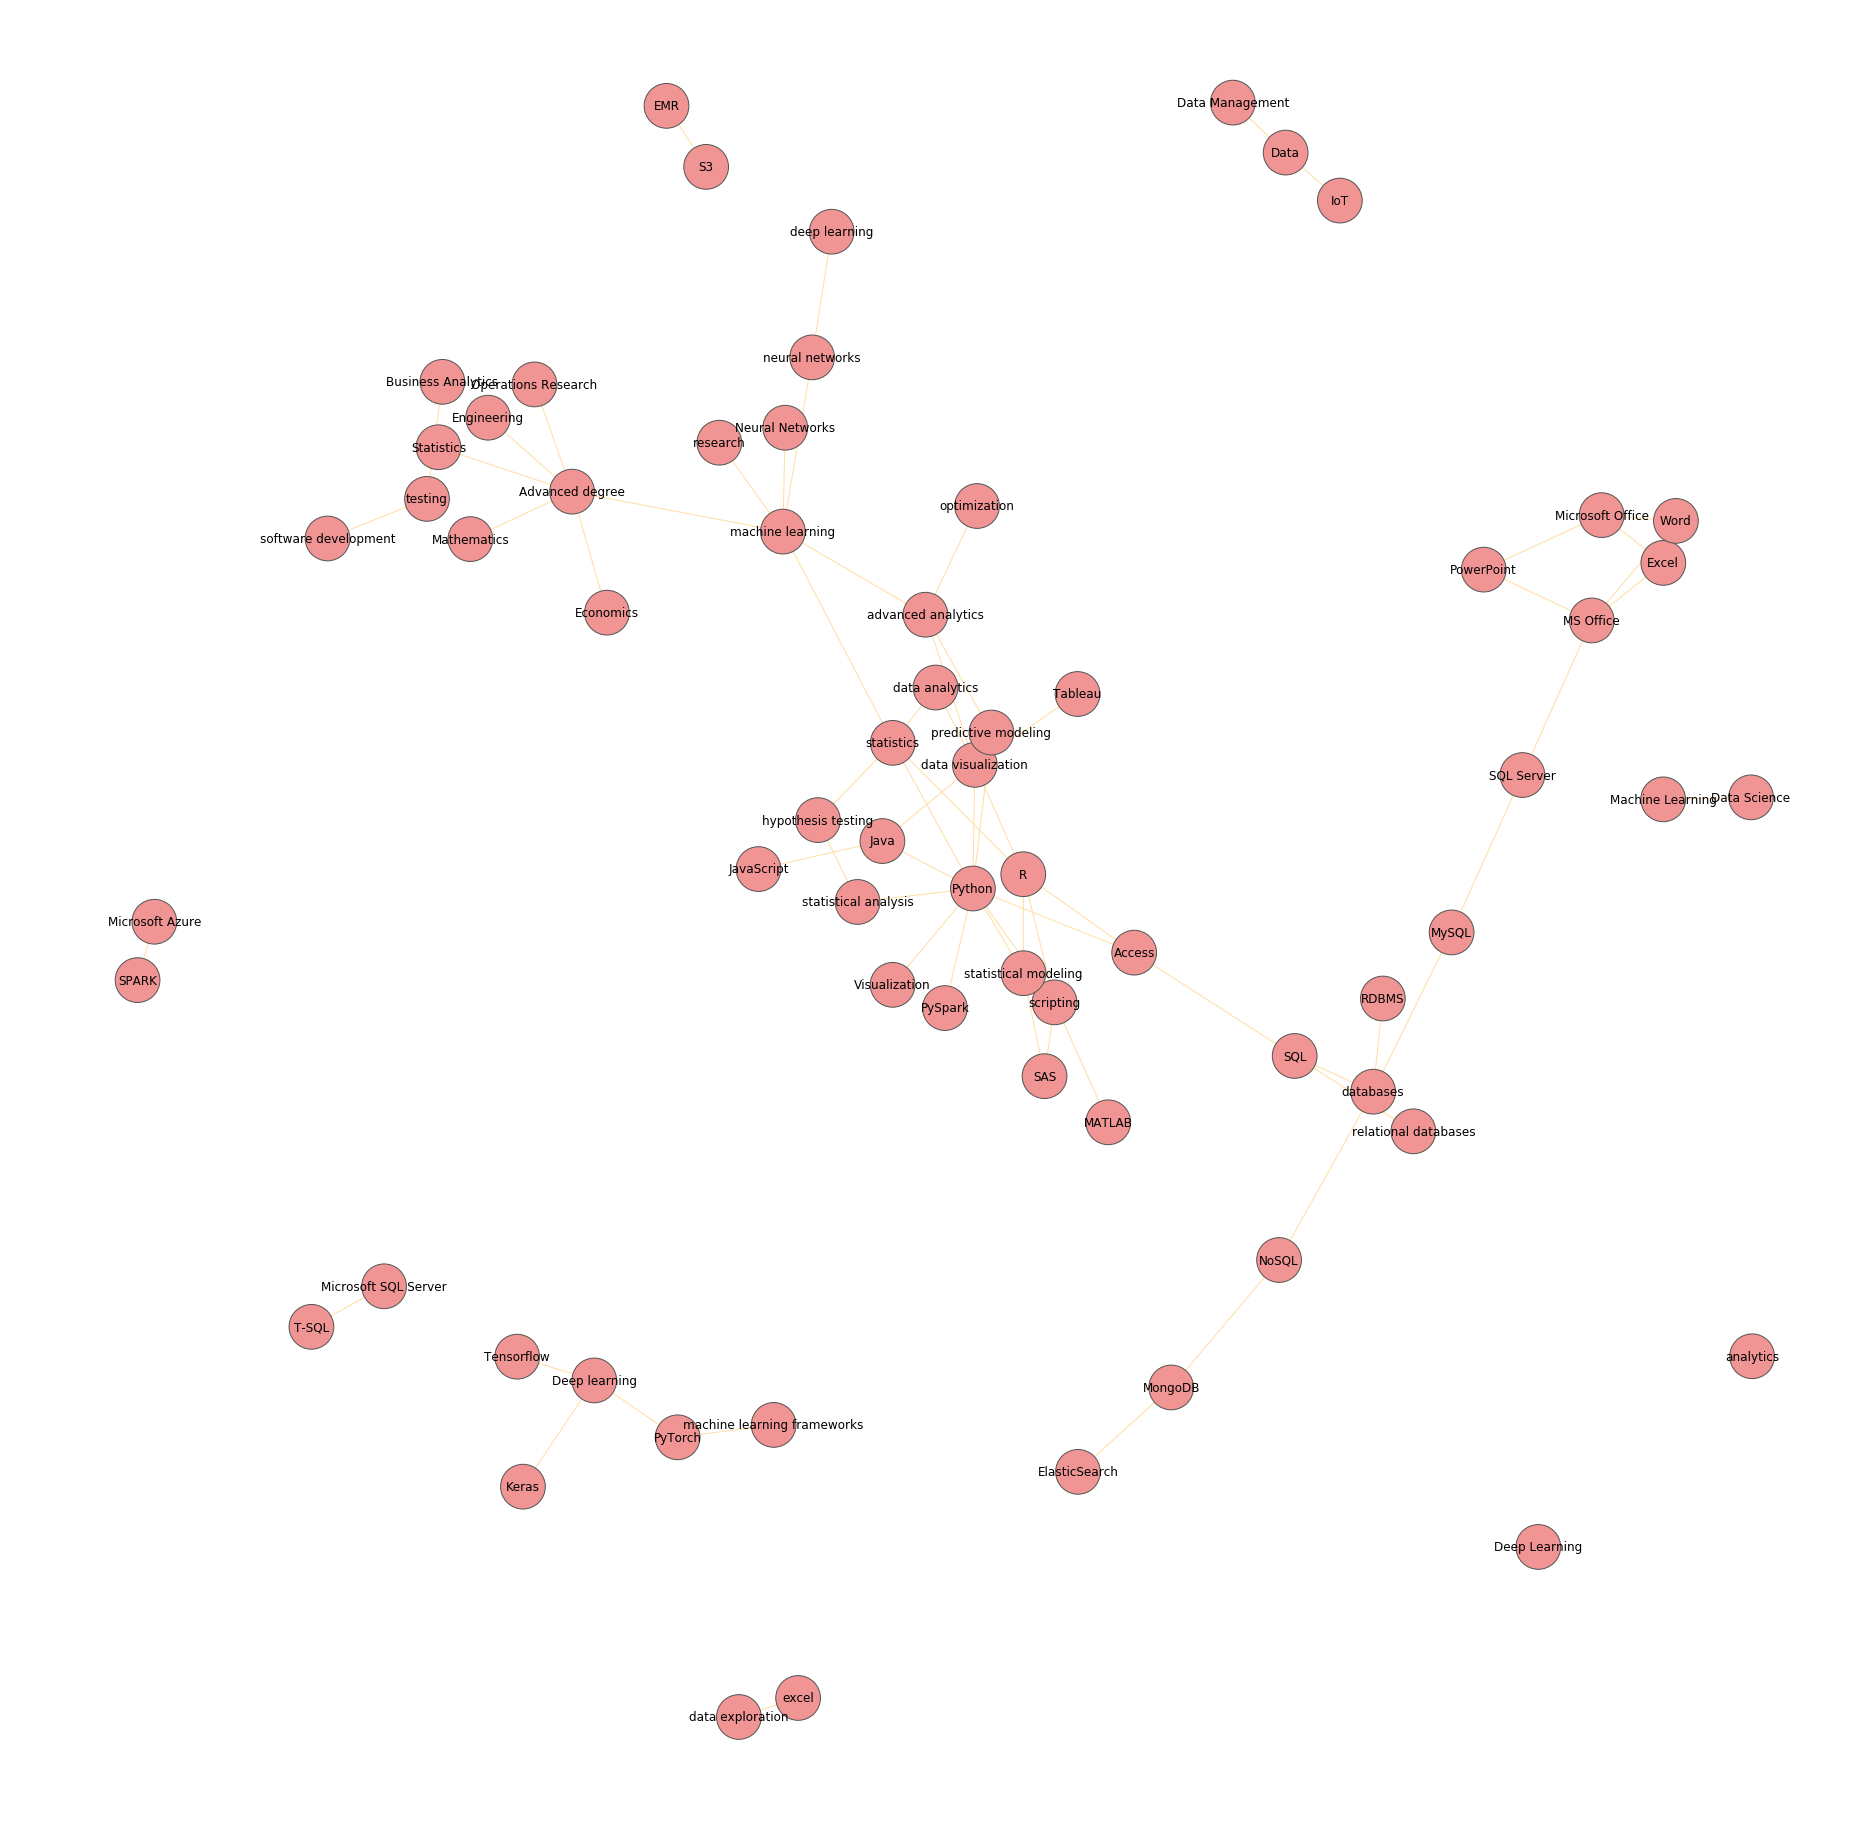

In [41]:
import warnings
warnings.filterwarnings('ignore')

G = nx.Graph(day="Stackoverflow")
# df_nodes = pd.read_csv('../input/stack_network_nodes.csv')
# df_edges = pd.read_csv('../input/stack_network_links.csv')

for index, row in link_df.iterrows():
    G.add_node(row['node1'], group=0, nodesize=200)
    G.add_node(row['node2'], group=0, nodesize=200)
    
for index, row in link_df.iterrows():
    G.add_weighted_edges_from([(row['node1'], row['node2'], 2)])
    
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'} 

plt.figure(figsize=(25,25))
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
colors = [color_map[1] for node in G]
sizes = [G.node[node]['nodesize']*10 for node in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()